In [2]:

import os
import sys
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import jpholiday

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from scipy import stats
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings("ignore")

# 作業ディレクトリの設定
try:
    os.chdir('H:/マイドライブ/03_code_test/clustering-house_trial')
    data_path_header = 'G:/マイドライブ/01_研究/02_円山町/1_データ前処理'
except FileNotFoundError:
    os.chdir('G:/マイドライブ/03_code_test/clustering-house_trial')
    data_path_header = 'H:/マイドライブ/01_研究/02_円山町/1_データ前処理'
print("Current Working Directory: ", os.getcwd())


# カスタムライブラリのパスを追加
sys.path.append(data_path_header)
from column_translation import column_translation_dict

def get_household_size(house_num):
    num_household_dict = {
        80	: 3,
        81	: 6,
        82	: 3,
        83	: 4,
        115	: 3,
        117	: 4,
        118	: 4,
        120	: 3,
        121	: 2,
        124	: 4,
        125	: 4,
        126	: 3,
        127	: 3,
        147	: 4,
        148	: 4,
        150	: 4,
        152	: 6,
        155	: 5,
        156	: 3,
        157	: 2,
        84	: 4,
        92	: 4,
        94	: 4,
        116	: 4,
        119	: 4,
        149	: 2,
        154	: 4,
        158	: 3,
        160	: 3,
        171	: 3,
        172	: 4,
    }
    return num_household_dict.get(house_num, None)

c:\Users\Yuasa\anaconda3\envs\umapfix\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current Working Directory:  H:\マイドライブ\03_code_test\clustering-house_trial


In [20]:
def show_nan_ratio(df: pd.DataFrame, name: str = "df") -> None:
    n_rows = len(df)
    n_nan_rows = df.isna().any(axis=1).sum()
    ratio = n_nan_rows / n_rows if n_rows > 0 else np.nan

    print(f"=== {name} ===")
    print(f"総行数: {n_rows}")
    print(f"欠損を1つ以上含む行数: {n_nan_rows}")
    print(f"欠損を含む行の割合: {ratio:.3%}")  # パーセンテージ表示


agg = 'monthly'
df_data = pd.read_csv(f'./output_feature/combined_{agg}_features.csv')

show_nan_ratio(df_data, name=f"combined_{agg}_features")
show_nan_ratio(df_data[['house_id', 'agg', 'date', 'mEDm']], name="mean ED")

print(f'\n元データ: {df_data.shape}\n')


# 欠損処理（中央値補完）
# df_dropped = df_data.drop(['house_id', 'agg', 'date', 'mEDm'], axis=1)
# df_dropped = df_dropped.replace([np.inf, -np.inf], np.nan).astype("float64")
# imp = SimpleImputer(strategy="median")
# X = imp.fit_transform(df_dropped)
# clean_imputed = pd.DataFrame(X, columns=df_dropped.columns, index=df_dropped.index)
# df_features = clean_imputed

# 欠損処理（欠損行削除）
df_replaced = df_data.replace([np.inf, -np.inf], np.nan)
df_dropped = df_replaced.dropna(how='any', axis=0).reset_index(drop=True)
df_features = df_dropped.drop(['house_id', 'agg', 'date'], axis=1)
df_features = df_features.astype("float64").round(4)

show_nan_ratio(df_features, name="after dropna")

# 正規化
mm = preprocessing.MinMaxScaler()
df_features_mm = pd.DataFrame(mm.fit_transform(df_features), columns=df_features.columns)

print(f'\n正規化後データ: {df_features_mm.shape}\n')


=== combined_monthly_features ===
総行数: 1428
欠損を1つ以上含む行数: 551
欠損を含む行の割合: 38.585%
=== mean ED ===
総行数: 1428
欠損を1つ以上含む行数: 0
欠損を含む行の割合: 0.000%

元データ: (1428, 158)

=== after dropna ===
総行数: 877
欠損を1つ以上含む行数: 0
欠損を含む行の割合: 0.000%

正規化後データ: (877, 155)



サンプル数が十分にあるため、次元削減は実施しない


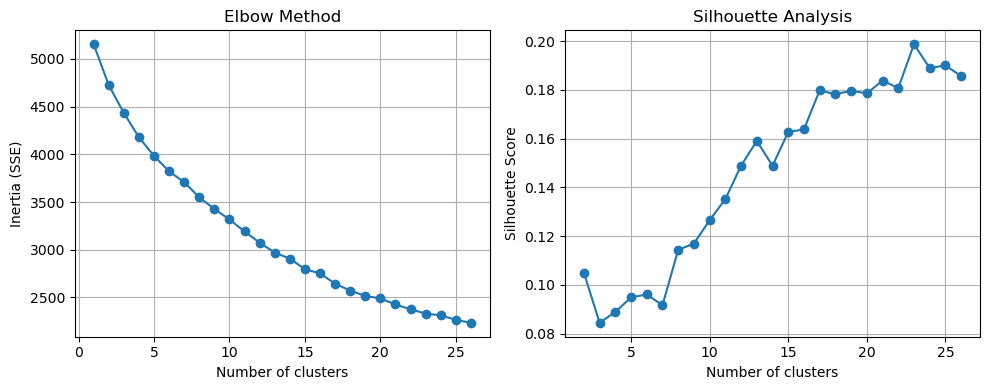

シルエットスコア最大のkの候補: 23


In [21]:
if df_features_mm.shape[0] / df_features_mm.shape[1] < 2:
    print("サンプル数が少ないため、PCAで次元削減を実施")
    # PCAで次元削減
    n_pca_components = df_features_mm.shape[0]/2.5  # サンプル数や特徴量数に応じて調整
    pca = PCA(n_components=n_pca_components, random_state=42)
    df_features_pca = pca.fit_transform(df_features_mm)
    df_features_mm = df_features_pca
else:
    print("サンプル数が十分にあるため、次元削減は実施しない")

# =========================
# エルボー法
inertia = []
K_range = range(1, 27)  # 1〜14クラスタで確認
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_features_mm)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")
plt.grid(True)

# =========================
# シルエット分析
sil_scores = []
K_range_sil = range(2, 27)  # シルエットスコアはk>=2
for k in K_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_features_mm)
    score = silhouette_score(df_features_mm, labels)
    sil_scores.append(score)

plt.subplot(1, 2, 2)
plt.plot(K_range_sil, sil_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.grid(True)

plt.tight_layout()
plt.show()

# =========================
# 推奨kの候補表示
best_sil_idx = sil_scores.index(max(sil_scores))
recommended_k = K_range_sil[best_sil_idx]
print(f"シルエットスコア最大のkの候補: {recommended_k}")

In [24]:
print('---kmeans clusters---')
k = 13 # クラスター数を指示
kmeanModel = KMeans(n_clusters=k, random_state=42)
kmeanModel.fit(df_features_mm)
clusters_kmeans = kmeanModel.labels_
# クラスターごとに何サンプルあるか
for i in range(k):
    num = list(clusters_kmeans).count(i)
    print(f'Cluster {i}: n = {num}')

list_clusters_kmeans = list(set(clusters_kmeans))
colors_kmeans = plt.cm.get_cmap("hsv", len(list_clusters_kmeans))
print(len(list_clusters_kmeans), list_clusters_kmeans)

print('---house clusters---')
clusters_str = df_dropped['house_id'].astype(str)
le = LabelEncoder()
clusters_house = le.fit_transform(clusters_str)
list_clusters_house = list(set(le.classes_))
colors_house = plt.cm.get_cmap("hsv", len(list_clusters_house))
print(len(list_clusters_house), list_clusters_house)

print('---date clusters---')
clusters_str = df_dropped['date'].astype(str)
le = LabelEncoder()
clusters_month = le.fit_transform(clusters_str)
list_clusters_month = list(set(le.classes_))
colors_month = plt.cm.get_cmap("hsv", len(list_clusters_month))
print(len(list_clusters_month), list_clusters_month)


---kmeans clusters---
Cluster 0: n = 24
Cluster 1: n = 57
Cluster 2: n = 89
Cluster 3: n = 111
Cluster 4: n = 131
Cluster 5: n = 54
Cluster 6: n = 51
Cluster 7: n = 35
Cluster 8: n = 40
Cluster 9: n = 47
Cluster 10: n = 48
Cluster 11: n = 166
Cluster 12: n = 24
13 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
---house clusters---
39 ['123', '152', '85', '80', '122', '150', '81', '158', '147', '170', '126', '157', '82', '171', '153', '155', '160', '169', '84', '172', '173', '125', '119', '124', '83', '120', '117', '176', '115', '99', '156', '121', '127', '92', '148', '149', '93', '154', '118']
---date clusters---
48 ['2021-08', '2021-04', '2022-02', '2023-11', '2022-08', '2022-09', '2023-06', '2024-09', '2023-04', '2022-11', '2023-05', '2021-06', '2025-02', '2022-07', '2024-01', '2023-07', '2024-11', '2022-03', '2021-07', '2024-08', '2021-10', '2025-03', '2025-01', '2022-05', '2023-09', '2023-08', '2024-07', '2022-10', '2021-12', '2023-10', '2023-03', '2021-09', '2024-03', '2024-05', '2024

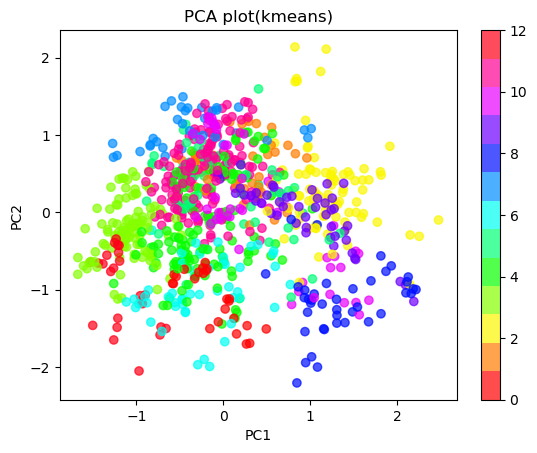

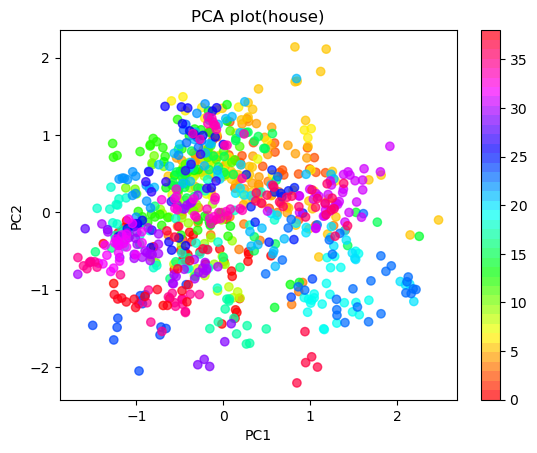

               CEVR    Eigenvalue    LD_actR_DT  BATH_actR_DT   BED_actR_DT  \
PC1    1.145986e-01  6.740727e-01  7.714756e-02  9.467544e-02  2.402429e-01   
PC2    9.350739e-02  5.500135e-01  2.428472e-01 -7.510796e-02 -1.950533e-01   
PC3    8.826684e-02  5.191884e-01 -4.308106e-02  3.101286e-01 -8.892233e-02   
PC4    6.538285e-02  3.845841e-01 -8.765841e-02  1.350845e-01 -3.972499e-02   
PC5    6.263449e-02  3.684181e-01  3.886784e-02 -9.404322e-02  2.438242e-02   
...             ...           ...           ...           ...           ...   
PC151  1.062868e-06  6.251824e-06 -1.659837e-03  1.072396e-03 -1.045962e-02   
PC152  9.232713e-07  5.430712e-06  1.482598e-03 -2.318112e-03 -5.787614e-03   
PC153  6.243183e-07  3.672261e-06 -7.094476e-04  6.959901e-04  4.018602e-04   
PC154  2.466992e-07  1.451093e-06  1.208553e-03 -1.987354e-04 -3.010855e-04   
PC155  3.144194e-14  1.849425e-13 -7.722023e-08 -4.529341e-08 -6.753560e-07   

         DW_actR_DT    ED_actR_DT    KT_actR_DT    

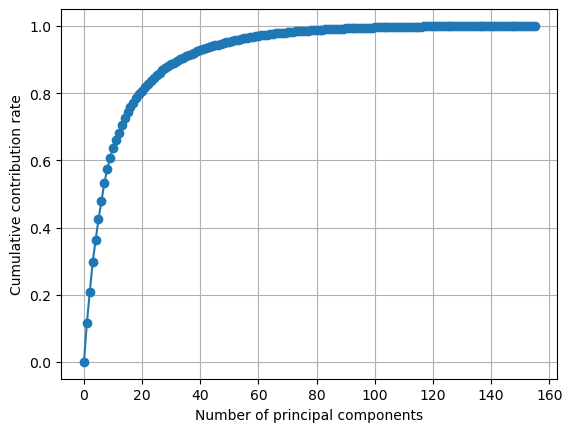

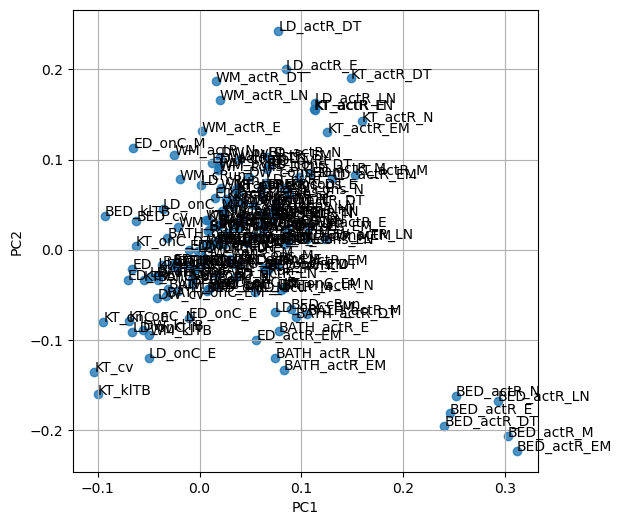

In [27]:
pca = PCA(random_state=42)
pca.fit(df_features_mm)
score = pd.DataFrame(pca.transform(df_features_mm))#, index=df_features.index)
# pca.explained_variance_ratio_

plt.scatter(score.iloc[:,0], score.iloc[:,1],
            c=clusters_kmeans, cmap=colors_kmeans, alpha=0.7)
plt.title('PCA plot(kmeans)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

plt.scatter(score.iloc[:,0], score.iloc[:,1],
            c=clusters_house, cmap=colors_house, alpha=0.7)
plt.title('PCA plot(house)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

# plt.scatter(score.iloc[:,0], score.iloc[:,1],
#             c=clusters_month, cmap=colors_month, alpha=0.7)
# plt.title('PCA plot(month)')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.colorbar()
# plt.show()

df_pca_performance = pd.DataFrame()
# 寄与率
CEVR = pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(df_features.columns))], columns=["CEVR"])
# 固有値
Eigenvalue = pd.DataFrame(pca.explained_variance_, index=["PC{}".format(x + 1) for x in range(len(df_features.columns))], columns=["Eigenvalue"])
# 固有ベクトル
Eigenvector = pd.DataFrame(pca.components_, columns=df_features.columns, index=["PC{}".format(x + 1) for x in range(len(df_features.columns))])

df_pca_performance = pd.concat([CEVR, Eigenvalue, Eigenvector], axis=1)

print(df_pca_performance)

# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

# 第一主成分と第二主成分における観測変数の寄与度をプロットする
plt.figure(figsize=(6, 6))
for x, y, name in zip(pca.components_[0], pca.components_[1], df_features_mm.columns):
    plt.text(x, y, name)
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


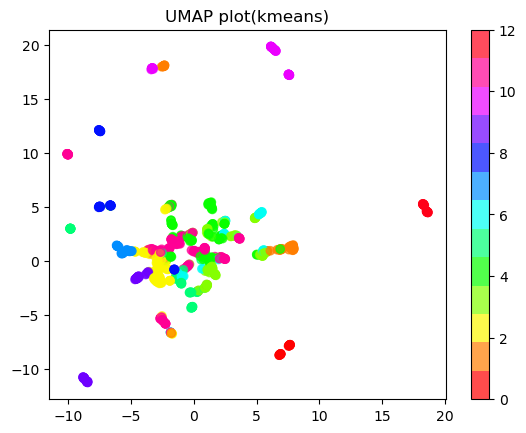

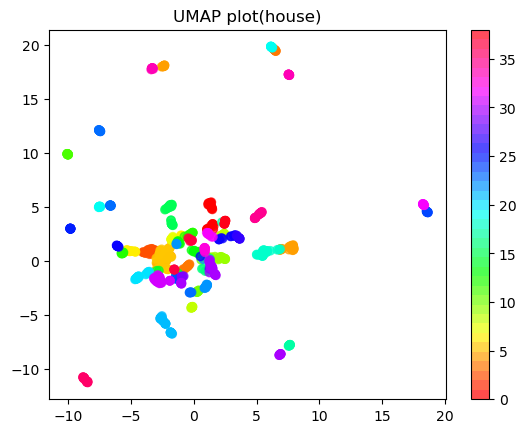

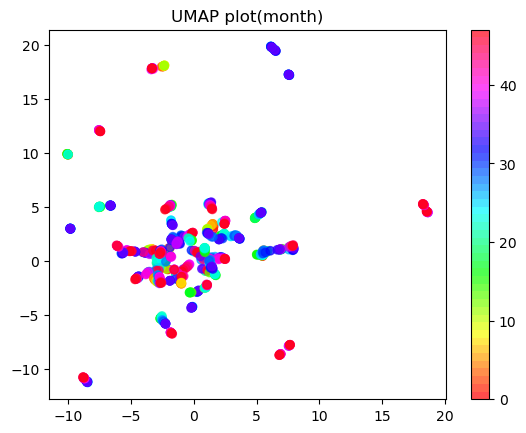

In [28]:

mapper = umap.UMAP(random_state=42)
embedding = mapper.fit_transform(df_features_mm)

plt.scatter(embedding[:, 0], embedding[:, 1],
    c=clusters_kmeans, cmap=colors_kmeans, alpha=0.7)
plt.title('UMAP plot(kmeans)')
plt.colorbar()
plt.show()

plt.scatter(embedding[:, 0], embedding[:, 1],
    c=clusters_house, cmap=colors_house, alpha=0.7)
plt.title('UMAP plot(house)')
plt.colorbar()
plt.show()

plt.scatter(embedding[:, 0], embedding[:, 1],
    c=clusters_month, cmap=colors_month, alpha=0.7)
plt.title('UMAP plot(month)')
plt.colorbar()
plt.show()

In [ ]:
# N = len(df_features.columns)
# cols = 5
# rows = math.ceil(N / cols)

# fig = plt.figure(figsize=(3*cols,3*rows))
# features_cols = df_features.columns

# for i, col in enumerate(features_cols):
#     ax = fig.add_subplot(rows, cols, i+1, title=col)
#     ax.scatter(embedding[:, 0], embedding[:, 1],
#         c=df_features[col], cmap='plasma', alpha=0.8)
# fig.tight_layout()
# plt.show()

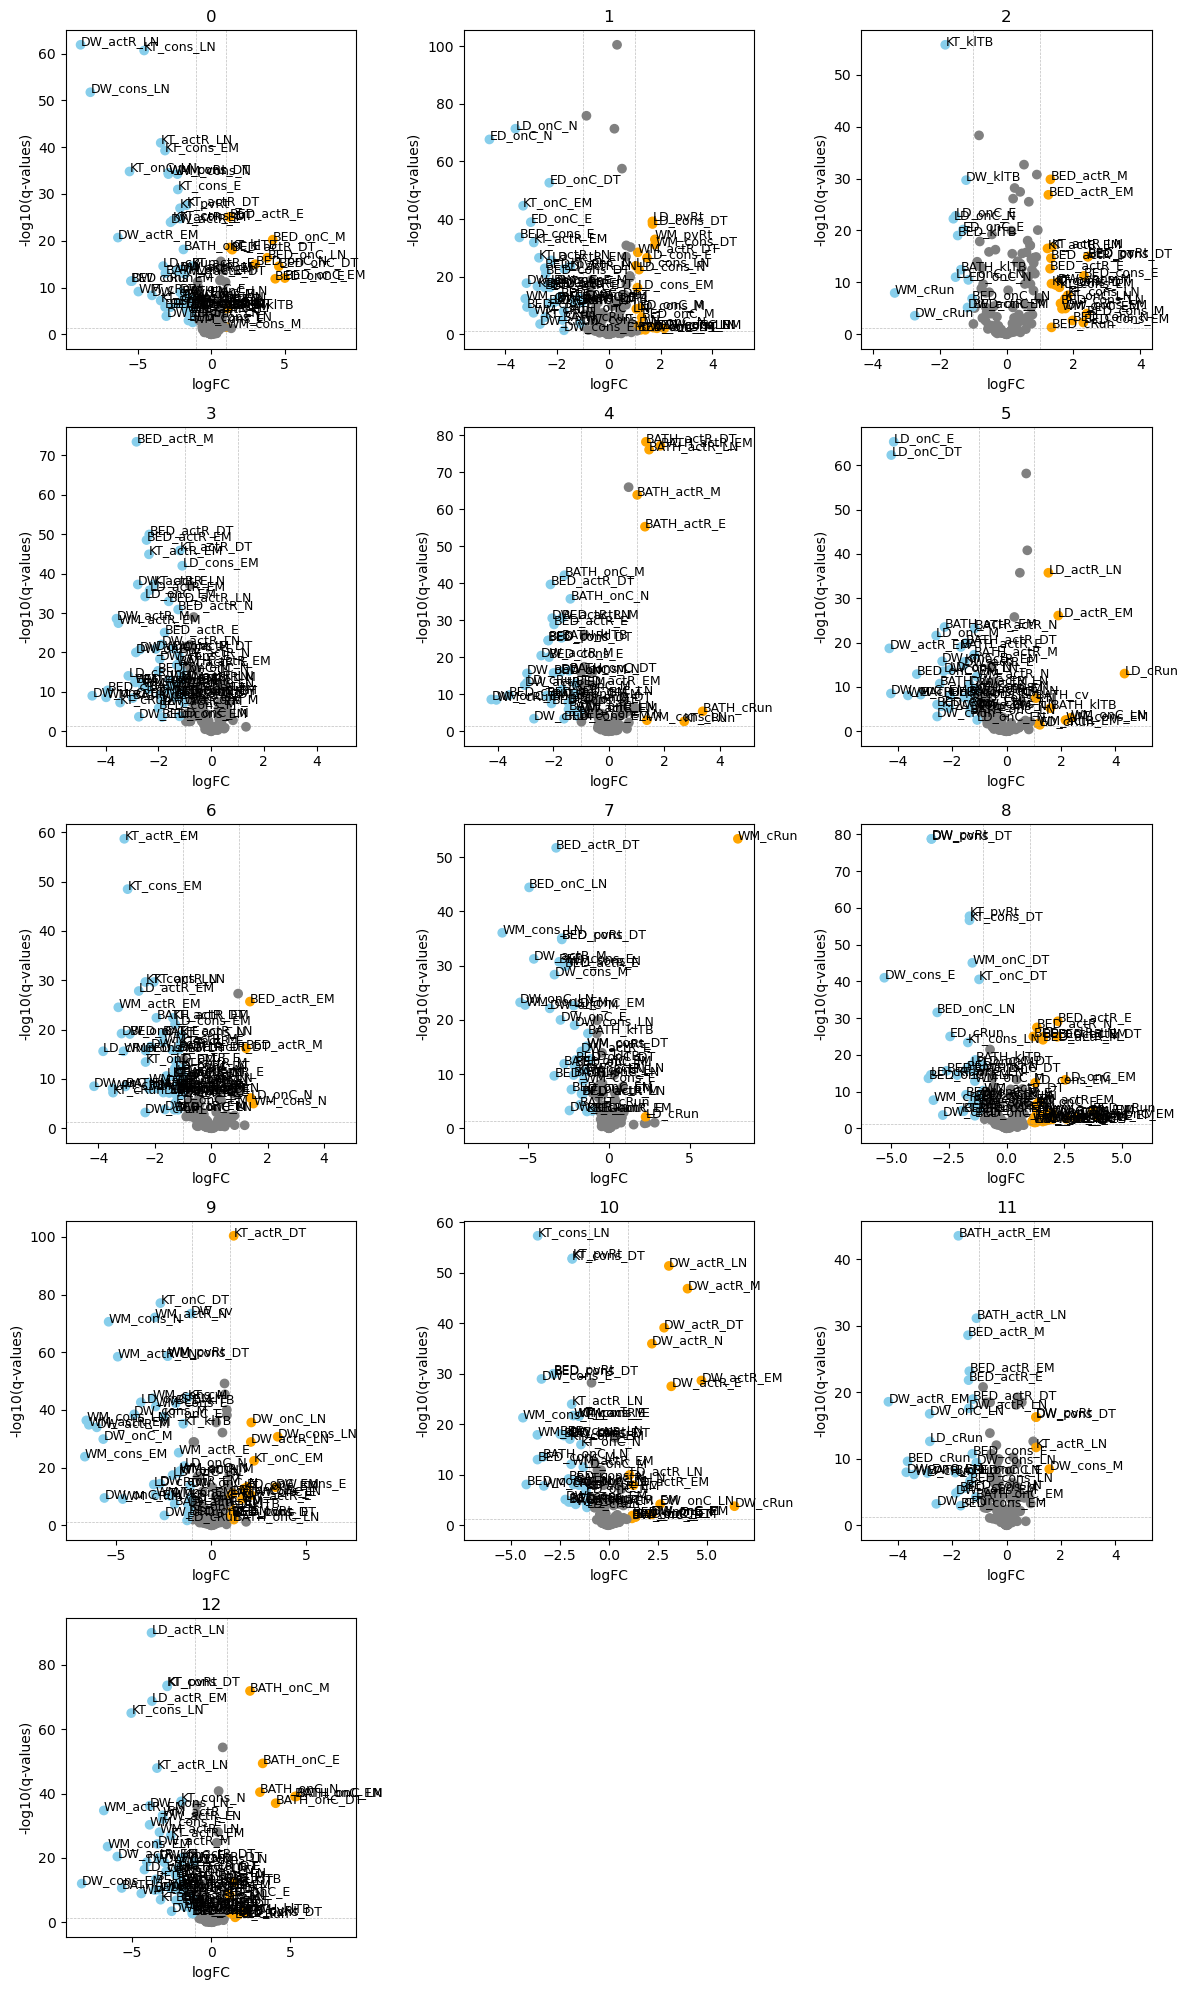

In [29]:


clusters = clusters_kmeans
list_clusters = list_clusters_kmeans

df_features_with_clusters = df_features.copy()
df_features_with_clusters['cluster'] = clusters
features_cols = df_features.columns

# 閾値を定める。ここでは補正後のp値 (q値) が0.05以下かつ数値の比 (Fold Change:fc)が2倍以上あるか、を閾値とします。
q_threshold = 0.05
fc_threshold = 2

import math
N = len(set(clusters))
cols = 3
rows = math.ceil(N / cols)
fig = plt.figure(figsize=(4*cols, 4*rows))
# クラスターごとに評価する
for i in range(len(set(clusters))):
    p_values = []
    fcs = []
    # 変数 = プロット上の1点
    for col in features_cols:
        # 検定
        group_1 = df_features_with_clusters[df_features_with_clusters['cluster'] == i][col]
        group_2 = df_features_with_clusters[df_features_with_clusters['cluster'] != i][col]
        p_value = stats.ttest_ind(group_1, group_2, equal_var=False)[1]
        p_values.append(p_value)

        # Fold change. 平均での比較が不適切であればここをmedian等に変える
        fc = group_1.mean()/group_2.mean()
        fcs.append(fc)

    # p-valueの補正
    q_values = multipletests(p_values, method='fdr_bh')[1]

    # 閾値を超えたものは色を変える
    colors = []
    for col, q_value, fc in zip(features_cols, q_values, fcs):
        # 対象がその他の2倍大きいときはオレンジ
        if q_value < q_threshold and fc > fc_threshold:
            colors.append('orange')
        # その他が対象の2倍大きいときは水色
        elif q_value < q_threshold and fc < 1/fc_threshold:
            colors.append('skyblue')
        # 大きな違いがない場合は灰色
        else:
            colors.append('gray')

    ax = fig.add_subplot(rows, cols, i+1)
    ax.scatter(np.log2(fcs), -np.log10(q_values),
    c=colors)

    # 図をきれいに見せるためのあれこれ。好みの世界
    max_val = max(abs(np.nanmin(np.log2(fcs)[np.log2(fcs) != -np.inf])), max(np.log2(fcs)))
    ax.set_xlim([-max_val-1, max_val+1]) # -infがあるので。-inf = そのクラスターでは全員が0
    ax.set_ylim(ax.get_ylim())
    # 閾値に点線をつける
    ax.hlines([-np.log10(q_threshold)], -max_val-1, max_val+1, 'gray', 'dashed', linewidth=0.5, alpha=0.5)
    ax.vlines([np.log2(fc_threshold), np.log2(1/fc_threshold)], ax.get_ylim()[0], ax.get_ylim()[1], 'gray', 'dashed', linewidth=0.5, alpha=0.5)

    # ラベルとアノテーション
    ax.set_title(f'{list_clusters[i]}')
    ax.set_xlabel('logFC')
    ax.set_ylabel('-log10(q-values)')
    for j, label in enumerate(features_cols):
        if colors[j] in ['orange', 'skyblue']:
            ax.annotate(label, (np.log2(fcs)[j], -np.log10(q_values)[j]), size=9)


# fig.suptitle('Volcano plots')
fig.tight_layout()
plt.show()

In [ ]:
cols = df_features_mm.columns

cols = ['LD_act-pro_0-6', 'LD_act-pro_6-12', 'LD_act-pro_12-18', 'LD_act-pro_18-24',
'bath_act-pro_0-6', 'bath_act-pro_6-12', 'bath_act-pro_12-18', 'bath_act-pro_18-24',
'bed_act-pro_0-6', 'bed_act-pro_6-12', 'bed_act-pro_12-18', 'bed_act-pro_18-24',
'DW_act-pro_0-6', 'DW_act-pro_6-12', 'DW_act-pro_12-18', 'DW_act-pro_18-24',
'KT_act-pro_0-6', 'KT_act-pro_6-12', 'KT_act-pro_12-18', 'KT_act-pro_18-24',
'WM_act-pro_0-6', 'WM_act-pro_6-12', 'WM_act-pro_12-18', 'WM_act-pro_18-24',]

replace_map = {
    "act-pro": "act",
    "time_bin": "consumption",
}
def replace_multi(s):
    for old, new in replace_map.items():
        s = s.replace(old, new)
    return s
plot_cols = [replace_multi(col) for col in cols]

df_features_mm_clusters = df_features_mm.copy()
df_features_mm_clusters['cluster'] = clusters_kmeans
labels = [f'{i}' for i in range(k)]
x = []
y = []
targets = []
colors = []
for i, col in enumerate(cols):
    for j, cluster_name in enumerate(clusters_kmeans):
        target_value = df_features_mm_clusters[df_features_mm_clusters['cluster']==j][col].mean()
        x.append(j)
        y.append(i)
        targets.append(np.exp(1+target_value*4)) # ここはVolcano plotsを見ながら調整
plt.figure(figsize=(4, 7))
plt.scatter(x, y, s=targets, c=targets, cmap='plasma')
plt.xticks(list(range(k)), labels, fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.yticks(list(range(len(cols))), plot_cols, fontsize=14)
plt.tick_params(axis='y', which='major', pad=6)
# --- 4行ごとに横線を引く ---
for yline in range(4, len(cols), 4):
    plt.axhline(y=yline - 0.5, color='gray', linestyle='--', linewidth=0.5)
plt.show()